Graph Attention Model Training and Testing

In [1]:
import numpy as np
import torch
from torch.nn import MSELoss
from torch.optim import Adam
from sklearn.metrics import mean_absolute_error

def train_gat(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):

    # Create dictionary to save all results (used for plots)
    results_dict = {
        'train_loss': [],
        'train_mae': [],
        'val_loss': [],
        'val_mae': [],
        'train_preds': [],
        'train_targets': [],
        'val_preds': [],
        'val_targets': [],
    }

    # Start model, with Adam optimizer and MSE loss
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    best_val_mae = float('inf')
    best_val_rmse = float('inf')
    best_model_state = None

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []

        train_preds = []
        train_targets = []

        # Train loop
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_fn(out, batch.y.float())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_preds.extend(out.detach().cpu().numpy())
            train_targets.extend(batch.y.cpu().numpy())

        train_mae = mean_absolute_error(train_targets, train_preds)

        model.eval()

        val_preds = []
        val_targets = []

        # Validation loop
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                val_preds.extend(out.cpu().numpy())
                val_targets.extend(batch.y.cpu().numpy())

        # Rest of function stores information of model
        val_mae = mean_absolute_error(val_targets, val_preds)
        val_rmse = np.sqrt(np.mean([(pred - target)**2 for pred, target in zip(val_preds, val_targets)]))

        print(f"Epoch {epoch:03d}: Train Loss = {sum(train_losses)/len(train_losses):.4f}, Val MAE = {val_mae:.2f}, Val RMSE = {val_rmse:.2f}")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_val_rmse = val_rmse
            best_model_state = model.state_dict()

            results_dict['train_preds'] = train_preds
            results_dict['train_targets'] = train_targets
            results_dict['val_preds'] = val_preds
            results_dict['val_targets'] = val_targets

        results_dict['train_loss'].append(sum(train_losses)/len(train_losses))
        results_dict['train_mae'].append(train_mae)

        val_losses = [(pred - target)**2 for pred, target in zip(val_preds, val_targets)]
        val_loss_epoch = sum(val_losses) / len(val_losses)
        results_dict['val_loss'].append(val_loss_epoch)
        results_dict['val_mae'].append(val_mae)
        

    return best_model_state, best_val_mae, best_val_rmse, results_dict


In [ ]:
from graph_attention_model import GATRegressor
from create_dataset import BrainGraphDataset

from sklearn.model_selection import StratifiedKFold
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler
import pickle
import numpy as np
import torch

# Load graphs
hcp_graphs = torch.load("hcp_brain_graph_dataset.pt", weights_only=False)
ppmi_graphs = torch.load("ppmi_brain_graph_dataset_new.pt", weights_only=False)

graph_list = hcp_graphs + ppmi_graphs
dataset = BrainGraphDataset(graph_list)

# Create labels: 0 = HCP, 1 = PPMI
graph_labels = np.array([0] * len(hcp_graphs) + [1] * len(ppmi_graphs))

# Set up stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = []

for train_idx, val_idx in skf.split(dataset, graph_labels):
    train_subset = [dataset[i] for i in train_idx]
    val_subset = [dataset[i] for i in val_idx]

    # Create sampler to "oversample" PPMI in training
    train_labels = graph_labels[train_idx]
    sample_weights = np.where(train_labels == 1, 5.0, 1.0)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_idx), replacement=True)

    train_loader = DataLoader(train_subset, batch_size=8, sampler=sampler)
    val_loader = DataLoader(val_subset, batch_size=8)

    folds.append((train_loader, val_loader))

## Train and validate model for all folds
all_fold_maes = []
all_fold_rmses = []
all_results = {}

for fold, (train_loader, val_loader) in enumerate(folds):
    print(f"\nFold {fold+1} --------------------------")

    # Can change hyperparameters here
    model = GATRegressor(in_channels=4, hidden_channels=64, heads=4)
    best_state, best_mae, best_rmse, results = train_gat(model, train_loader, val_loader, lr=1e-4, epochs=50)

    torch.save(best_state, f"gat_fold{fold+1}_best_model.pt")

    # Evaluate success of model
    print(f"Fold {fold+1} Best MAE: {best_mae:.2f}, Best RMSE: {best_rmse:.2f}")
    all_fold_maes.append(best_mae)
    all_fold_rmses.append(best_rmse)
    all_results[fold] = results

print("\nCross-validation summary:")
print(f"MAE per fold: {all_fold_maes}")
print(f"Mean MAE: {sum(all_fold_maes)/len(all_fold_maes):.2f}")

# Save results for plotting
with open("training_results.pkl", "wb") as f:
    pickle.dump(all_results, f)



Fold 1 --------------------------
Epoch 001: Train Loss = 84046.7769, Val MAE = 18.56, Val RMSE = 23.60
Epoch 002: Train Loss = 1312.8610, Val MAE = 8.75, Val RMSE = 17.26
Epoch 003: Train Loss = 795.6152, Val MAE = 8.29, Val RMSE = 14.86
Epoch 004: Train Loss = 641.5888, Val MAE = 11.69, Val RMSE = 14.53
Epoch 005: Train Loss = 537.1790, Val MAE = 8.33, Val RMSE = 11.46
Epoch 006: Train Loss = 496.9230, Val MAE = 5.81, Val RMSE = 9.64
Epoch 007: Train Loss = 322.5262, Val MAE = 4.24, Val RMSE = 6.18
Epoch 008: Train Loss = 274.1289, Val MAE = 6.80, Val RMSE = 7.67
Epoch 009: Train Loss = 201.1462, Val MAE = 4.31, Val RMSE = 5.50
Epoch 010: Train Loss = 210.7611, Val MAE = 4.45, Val RMSE = 5.71
Epoch 011: Train Loss = 153.9927, Val MAE = 3.86, Val RMSE = 5.15
Epoch 012: Train Loss = 153.4748, Val MAE = 4.55, Val RMSE = 6.24
Epoch 013: Train Loss = 119.2142, Val MAE = 4.74, Val RMSE = 6.32
Epoch 014: Train Loss = 118.6211, Val MAE = 4.10, Val RMSE = 5.90
Epoch 015: Train Loss = 94.5282

In [25]:
print("\nCross-validation summary:")
print(f"MAE per fold: {all_fold_maes}")
print(f"RMSE per fold: {all_fold_rmses}")
print(f"Mean MAE: {sum(all_fold_maes)/len(all_fold_maes):.4f}")
print(f"Mean RMSE: {sum(all_fold_rmses)/len(all_fold_rmses):.4f}")


Cross-validation summary:
MAE per fold: [3.7520171923515124, 5.014573268401317, 3.2915172576904297, 3.3970787341778097, 3.923462647658128, 3.9910461719219503, 4.061422739273462, 3.755131403605143, 3.8150770725348058, 3.634457074678861]
RMSE per fold: [np.float32(5.2442), np.float32(5.888731), np.float32(4.2416825), np.float32(4.898218), np.float32(5.198413), np.float32(6.2825904), np.float32(4.8564916), np.float32(6.511677), np.float32(5.433017), np.float32(4.1896567)]
Mean MAE: 3.8636
Mean RMSE: 5.2745


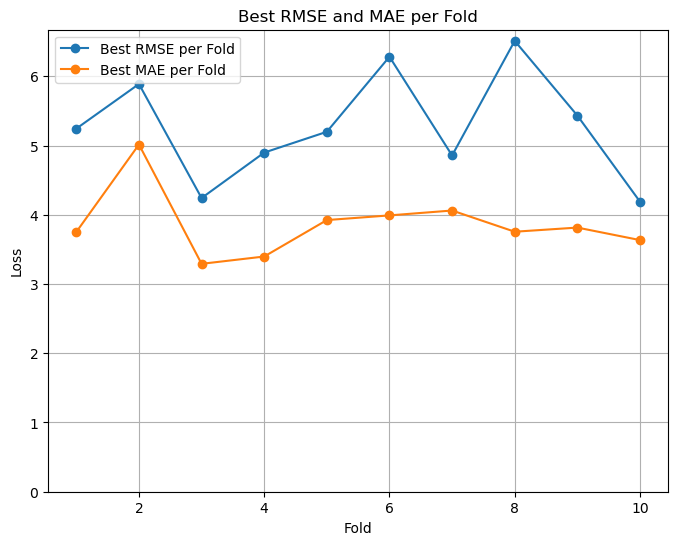

In [6]:
import matplotlib.pyplot as plt

folds = list(range(1, len(all_fold_maes) + 1))

plt.figure(figsize=(8, 6))
plt.plot(folds, all_fold_rmses, marker='o', label='Best RMSE per Fold')
plt.plot(folds, all_fold_maes, marker='o', label='Best MAE per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Best RMSE and MAE per Fold')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()


In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import nibabel as nib
from nilearn import plotting
import pandas as pd

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATRegressor(in_channels=4, hidden_channels=64, heads=4)
model.load_state_dict(torch.load('gat_fold5_best_model.pt', map_location=device, weights_only=False))
model = model.to(device)
model.eval()

# Load dataset
dataset = BrainGraphDataset(torch.load('hcp_brain_graph_dataset.pt', weights_only=False) + torch.load('ppmi_brain_graph_dataset.pt', weights_only=False))
dataloader = DataLoader(dataset, batch_size=1)
num_nodes = dataset[0].num_nodes

node_attention_sum = torch.zeros(num_nodes, device=device)
node_counts = torch.zeros(num_nodes, device=device)

# Analyze attention
for data in dataloader:
    data = data.to(device)
    x, edge_index, batch = data.x, data.edge_index, data.batch

    # Get first GAT layer attention
    x1, (edge_idx1, attn_weights1) = model.gat1(x, edge_index, return_attention_weights=True)
    attn_mean = attn_weights1.mean(dim=1)
    dest_nodes = edge_idx1[1]

    for idx, dest in enumerate(dest_nodes):
        node_attention_sum[dest] += attn_mean[idx]
        node_counts[dest] += 1

# Normalize attention by number of times each node was visited
avg_node_attention = node_attention_sum / (node_counts + 1e-8)

# Find top 10 nodes
topk = 10
topk_nodes = torch.topk(avg_node_attention, k=topk)

print("Top 10 most important nodes:")
for rank, (node_idx, score) in enumerate(zip(topk_nodes.indices.tolist(), topk_nodes.values.tolist()), 1):
    print(f"{rank}. Node {node_idx} with score {score:.4f}")

def load_freesurfer_lut(lut_path):
    """Reads FreeSurfer LUT and returns a {label: region_name} dictionary."""
    lut_dict = {}
    with open(lut_path, 'r') as f:
        for line in f:
            if line.strip() == '' or line.strip().startswith('#'):
                continue
            
            parts = line.strip().split()
            if len(parts) >= 2:
                try:
                    label_num = int(parts[0])
                    label_name = parts[1]
                    lut_dict[label_num] = label_name
                except ValueError:
                    continue
    return lut_dict

lut_path = '/projectnb/ec523/projects/proj_GS_LQ_EPB/models/T1stats_GNN/FsTutorial_AnatomicalROI_FreeSurferColorLUT.txt'
freesurfer_lut = load_freesurfer_lut(lut_path)

def build_label_list(segmentation_path):
    """Builds sorted label list from a segmentation file."""
    seg = nib.load(segmentation_path).get_fdata()
    labels = np.unique(seg)
    labels = labels[labels != 0]
    return sorted(labels.astype(int))

segmentation_file = '/projectnb/ec523/projects/proj_GS_LQ_EPB/data/T1w_segmented/HCP_processed/100307/100307/mri/aparc.DKTatlas+aseg.deep.mgz'
label_list = build_label_list(segmentation_file)
print(label_list)

# === Top 10 Most Important Brain Regions ===
roi_rows = []
print("\nTop 10 Most Important Brain Regions:")
for rank, (node_idx, score) in enumerate(zip(topk_nodes.indices.tolist(), topk_nodes.values.tolist()), 1):
    label_number = label_list[node_idx]
    region_name = freesurfer_lut.get(label_number, f"Unknown Label {label_number}")
    print(f"{rank}. Node {node_idx} = Label {label_number} = {region_name} with score {score:.4f}")

    roi_rows.append({
        "atlas_index": label_number,
        "importance": float(score)
    })

roi_df = pd.DataFrame(roi_rows)
roi_csv_path = "roi_importance.csv"
roi_df.to_csv(roi_csv_path, index=False)
print(f"\nSaved top ROI importance to {roi_csv_path}")

## Use brain atlas
ATLAS_PATH = '/projectnb/ec523/projects/proj_GS_LQ_EPB/models/T1stats_GNN/template/aparc+aseg.mgz'
OUT_PREFIX = "dkt_roi_heatmap"

print(f"Using atlas: {ATLAS_PATH}")

## Build heatmap
atlas_img = nib.load(ATLAS_PATH)
atlas_data = atlas_img.get_fdata().astype(int)
heat = np.zeros_like(atlas_data, dtype=np.float32)

unique_labels = np.unique(atlas_data)
print("Unique labels in atlas:", unique_labels)
print("Number of unique labels:", len(unique_labels))

for _, row in roi_df.iterrows():
    label = int(row["atlas_index"])
    weight = float(row["importance"])
    heat[atlas_data == label] = weight

heat_img = nib.Nifti1Image(heat, affine=atlas_img.affine, header=atlas_img.header)
nib.save(heat_img, f"{OUT_PREFIX}.nii.gz")
print(f"Saved heatmap NIfTI to {OUT_PREFIX}.nii.gz")

## Plot glass brain
display = plotting.plot_glass_brain(
    heat_img,
    colorbar=True,
    plot_abs=False,
    threshold=1e-6,
    title="Top-ROI importance (DKT atlas)",
)
display.savefig(f"{OUT_PREFIX}_glass.png", dpi=300)
display.close()
print(f"Saved glass brain plot to {OUT_PREFIX}_glass.png")


Top 10 most important nodes:
1. Node 36 with score 0.3826
2. Node 67 with score 0.3271
3. Node 90 with score 0.3160
4. Node 59 with score 0.3157
5. Node 65 with score 0.3127
6. Node 34 with score 0.2961
7. Node 70 with score 0.2632
8. Node 22 with score 0.2593
9. Node 38 with score 0.2546
10. Node 69 with score 0.2542
[np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(24), np.int64(26), np.int64(28), np.int64(31), np.int64(41), np.int64(43), np.int64(44), np.int64(46), np.int64(47), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(58), np.int64(60), np.int64(63), np.int64(77), np.int64(1002), np.int64(1003), np.int64(1005), np.int64(1006), np.int64(1007), np.int64(1008), np.int64(1009), np.int64(1010), np.int64(1011), np.int64(1012), np.int64(1013), np.int64(1014), np.int64(1015), np.int64(1016)

In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd

# Load your model
device = torch.device('cpu')
model = GATRegressor(in_channels=4, hidden_channels=64, heads=4)
model.load_state_dict(torch.load('gat_fold5_best_model.pt', map_location='cpu', weights_only=False))
model = model.to('cpu')
model.train()

# Load the graphs
adni_graphs = torch.load('adni_brain_graph_dataset.pt', map_location='cpu', weights_only=False)

adni_dataset = BrainGraphDataset(adni_graphs)
adni_loader = DataLoader(adni_dataset, batch_size=8, shuffle=True)  # small batches

import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Small LR for fine-tuning
epochs = 10

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for data in adni_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output.squeeze(), data.y.squeeze())  # Regression = MSE loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(adni_loader)
    print(f"Epoch {epoch} - Avg MSE Loss: {avg_loss:.4f}")

# Evaluate after fine-tuning
model.eval()

all_preds = []
all_targets = []

for data in adni_loader:
    output = model(data)
    preds = output.view(-1).detach().numpy()
    targets = data.y.view(-1).numpy()
    all_preds.extend(preds.tolist())
    all_targets.extend(targets.tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

mae = np.mean(np.abs(all_preds - all_targets))
rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))

torch.save(model.state_dict(), "gat_finetuned_on_adni.pt")

print(f"\nAFTER Fine-tuning on ADNI:")
print(f"ADNI MAE: {mae:.4f}")
print(f"ADNI RMSE: {rmse:.4f}")



Epoch 1 - Avg MSE Loss: 2009.6356
Epoch 2 - Avg MSE Loss: 1162.3388
Epoch 3 - Avg MSE Loss: 662.3371
Epoch 4 - Avg MSE Loss: 305.8184
Epoch 5 - Avg MSE Loss: 157.6215
Epoch 6 - Avg MSE Loss: 103.5220
Epoch 7 - Avg MSE Loss: 94.8596
Epoch 8 - Avg MSE Loss: 96.8812
Epoch 9 - Avg MSE Loss: 98.3416
Epoch 10 - Avg MSE Loss: 100.6850

AFTER Fine-tuning on ADNI:
ADNI MAE: 7.6516
ADNI RMSE: 9.8084


In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import nibabel as nib
from nilearn import plotting
import pandas as pd

device = torch.device('cpu')
model = GATRegressor(in_channels=4, hidden_channels=64, heads=4)
model.load_state_dict(torch.load('gat_finetuned_on_adni.pt', map_location='cpu', weights_only=False))
model = model.to('cpu')
model.eval()

adni_graphs = torch.load('adni_brain_graph_dataset.pt', map_location='cpu', weights_only=False)

for g in adni_graphs:
    if hasattr(g, 'group'):
        del g.group

adni_dataset = BrainGraphDataset(adni_graphs)
adni_loader = DataLoader(adni_dataset, batch_size=1)

## Evaluate results on new dataset

model.eval()

all_preds = []
all_targets = []

for data in adni_loader:
    output = model(data)
    preds = output.view(-1).detach().numpy()
    targets = data.y.view(-1).numpy()
    all_preds.extend(preds.tolist())
    all_targets.extend(targets.tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

mae = np.mean(np.abs(all_preds - all_targets))
rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))

print(f"\nAFTER Fine-tuning on ADNI:")
print(f"ADNI MAE: {mae:.4f}")
print(f"ADNI RMSE: {rmse:.4f}")



AFTER Fine-tuning on ADNI:
ADNI MAE: 7.6516
ADNI RMSE: 9.8084

Top 10 Most Important Nodes in ADNI Dataset:
1. Node 36 with score 0.3498
2. Node 67 with score 0.3275
3. Node 59 with score 0.3192
4. Node 90 with score 0.3183
5. Node 65 with score 0.3021
6. Node 34 with score 0.2770
7. Node 11 with score 0.2743
8. Node 69 with score 0.2534
9. Node 38 with score 0.2528
10. Node 76 with score 0.2500

Top 10 Most Important Brain Regions in ADNI Dataset:
1. Node 36 = Label 1006 = ctx-lh-entorhinal with score 0.3498
2. Node 67 = Label 2006 = ctx-rh-entorhinal with score 0.3275
3. Node 59 = Label 1029 = ctx-lh-superiorparietal with score 0.3192
4. Node 90 = Label 2029 = ctx-rh-superiorparietal with score 0.3183
5. Node 65 = Label 2003 = ctx-rh-caudalmiddlefrontal with score 0.3021
6. Node 34 = Label 1003 = ctx-lh-caudalmiddlefrontal with score 0.2770
7. Node 11 = Label 16 = Brain-Stem with score 0.2743
8. Node 69 = Label 2008 = ctx-rh-inferiorparietal with score 0.2534
9. Node 38 = Label 1008

In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import nibabel as nib
from nilearn import plotting
import pandas as pd

# ======= Load model on CPU =======

device = torch.device('cpu')
model = GATRegressor(in_channels=4, hidden_channels=64, heads=4)
model.load_state_dict(torch.load('gat_finetuned_on_adni.pt', map_location='cpu', weights_only=False))
model = model.to('cpu')
model.eval()

adni_graphs = torch.load('adni_brain_graph_dataset.pt', map_location='cpu', weights_only=False)

cn_graphs = []
for g in adni_graphs:
    if hasattr(g, 'group') and g.group == 'CN':
        cn_graphs.append(g)

print(f"Found {len(cn_graphs)} CN participants.")

cn_dataset = BrainGraphDataset(cn_graphs)
cn_loader = DataLoader(cn_dataset, batch_size=1)

model.eval()

all_preds = []
all_targets = []

for data in cn_loader:
    output = model(data)
    preds = output.view(-1).detach().numpy()
    targets = data.y.view(-1).numpy()
    all_preds.extend(preds.tolist())
    all_targets.extend(targets.tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

mae = np.mean(np.abs(all_preds - all_targets))
rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))

print(f"\nAFTER Fine-tuning on ADNI:")
print(f"CN-ONLY MAE: {mae:.4f}")
print(f"CN-ONLY RMSE: {rmse:.4f}")


Found 37 CN participants.

AFTER Fine-tuning on ADNI:
CN-ONLY MAE: 5.8681
CN-ONLY RMSE: 6.9785

Top 10 Most Important Nodes in CN Participants:
1. Node 36 with score 0.3814
2. Node 67 with score 0.3274
3. Node 59 with score 0.3190
4. Node 90 with score 0.3136
5. Node 65 with score 0.3008
6. Node 34 with score 0.2937
7. Node 11 with score 0.2741
8. Node 69 with score 0.2534
9. Node 38 with score 0.2517
10. Node 76 with score 0.2483

Top 10 Most Important Brain Regions (CN participants):
1. Node 36 = Label 1006 = ctx-lh-entorhinal with score 0.3814
2. Node 67 = Label 2006 = ctx-rh-entorhinal with score 0.3274
3. Node 59 = Label 1029 = ctx-lh-superiorparietal with score 0.3190
4. Node 90 = Label 2029 = ctx-rh-superiorparietal with score 0.3136
5. Node 65 = Label 2003 = ctx-rh-caudalmiddlefrontal with score 0.3008
6. Node 34 = Label 1003 = ctx-lh-caudalmiddlefrontal with score 0.2937
7. Node 11 = Label 16 = Brain-Stem with score 0.2741
8. Node 69 = Label 2008 = ctx-rh-inferiorparietal with

In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import nibabel as nib
from nilearn import plotting
import pandas as pd

device = torch.device('cpu')
model = GATRegressor(in_channels=4, hidden_channels=64, heads=4)
model.load_state_dict(torch.load('gat_finetuned_on_adni.pt', map_location='cpu', weights_only=False))
model = model.to('cpu')
model.eval()

adni_graphs = torch.load('adni_brain_graph_dataset.pt', map_location='cpu', weights_only=False)

ad_graphs = []
for g in adni_graphs:
    if hasattr(g, 'group') and g.group == 'AD':
        ad_graphs.append(g)

print(f"Found {len(ad_graphs)} AD participants.")

ad_dataset = BrainGraphDataset(ad_graphs)
ad_loader = DataLoader(ad_dataset, batch_size=1)

model.eval()

all_preds = []
all_targets = []

for data in ad_loader:
    output = model(data)
    preds = output.view(-1).detach().numpy()
    targets = data.y.view(-1).numpy()
    all_preds.extend(preds.tolist())
    all_targets.extend(targets.tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

mae = np.mean(np.abs(all_preds - all_targets))
rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))

print(f"\nAFTER Fine-tuning on ADNI:")
print(f"AD-ONLY MAE: {mae:.4f}")
print(f"AD-ONLY RMSE: {rmse:.4f}")

Found 23 AD participants.

AFTER Fine-tuning on ADNI:
AD-ONLY MAE: 9.5344
AD-ONLY RMSE: 12.5945

Top 10 Most Important Nodes in AD Participants:
1. Node 36 with score 0.3382
2. Node 90 with score 0.3239
3. Node 59 with score 0.3194
4. Node 67 with score 0.3194
5. Node 65 with score 0.3067
6. Node 11 with score 0.2911
7. Node 38 with score 0.2527
8. Node 34 with score 0.2527
9. Node 69 with score 0.2527
10. Node 76 with score 0.2500

Top 10 Most Important Brain Regions (AD participants):
1. Node 36 = Label 1006 = ctx-lh-entorhinal with score 0.3382
2. Node 90 = Label 2029 = ctx-rh-superiorparietal with score 0.3239
3. Node 59 = Label 1029 = ctx-lh-superiorparietal with score 0.3194
4. Node 67 = Label 2006 = ctx-rh-entorhinal with score 0.3194
5. Node 65 = Label 2003 = ctx-rh-caudalmiddlefrontal with score 0.3067
6. Node 11 = Label 16 = Brain-Stem with score 0.2911
7. Node 38 = Label 1008 = ctx-lh-inferiorparietal with score 0.2527
8. Node 34 = Label 1003 = ctx-lh-caudalmiddlefrontal wit